# 08 - A/B Test Simulation & ROI Analysis

## Purpose
This notebook simulates realistic A/B testing scenarios to demonstrate intervention effectiveness and ROI calculation. We model the complete experiment lifecycle from design to analysis, including power calculations, sample size determination, and financial impact assessment.

## Why A/B Test Simulation Matters
Before deploying expensive interventions in production, stakeholders need concrete evidence of:
- **Statistical Validity**: Will our test detect real effects?
- **Financial ROI**: What's the expected return on investment?
- **Risk Assessment**: What if interventions don't work as expected?
- **Resource Planning**: How long will tests need to run?

## What This Notebook Covers
1. **Power Analysis**: Calculate required sample sizes for detection
2. **Test Simulation**: Model multiple intervention scenarios
3. **Sequential Testing**: Monitor tests for early stopping
4. **Segmented Analysis**: Heterogeneous treatment effects
5. **ROI Calculation**: Revenue impact after costs
6. **Sensitivity Analysis**: How robust are our conclusions?
7. **Production Deployment Strategy**: Gradual rollout planning

## Business Value
Proper A/B testing prevents costly mistakes. This analysis demonstrates:
- Expected revenue lift from interventions
- Break-even analysis for different scenarios
- Risk quantification (probability of negative ROI)
- Optimal allocation of intervention budget

---
## Setup

In [8]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Statistical testing
from scipy import stats
from scipy.stats import beta, binom, norm
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Project paths
project_root = Path.cwd().parent
data_extracts = project_root / 'data' / 'extracts'
results_dir = project_root / 'results'
figures_dir = results_dir / 'figures'

figures_dir.mkdir(parents=True, exist_ok=True)

# Plotting configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("A/B Testing Simulation Framework Initialized")
print("This notebook provides rigorous statistical analysis of intervention effectiveness")

A/B Testing Simulation Framework Initialized
This notebook provides rigorous statistical analysis of intervention effectiveness


---
## 1. Power Analysis & Sample Size Calculation

Determine how many users we need in our test to detect meaningful effects with statistical confidence.

In [9]:
print("="*80)
print(" "*25 + "POWER ANALYSIS")
print("="*80)

# Load baseline metrics (leak-safe export)
ml_features = pd.read_parquet(data_extracts / 'ml_features.parquet')

TARGET_COL = "target"
if TARGET_COL not in ml_features.columns:
    raise ValueError(f"Missing '{TARGET_COL}' in ml_features.parquet. Re-export from Notebook 03.")

baseline_conv_rate = ml_features[TARGET_COL].mean()
print(f"\nBaseline Conversion Rate (all sessions): {baseline_conv_rate*100:.3f}%")

# Define test scenarios (relative lift)
scenarios = [
    {'name': 'Conservative', 'lift': 0.05, 'description': '5% relative lift'},
    {'name': 'Realistic', 'lift': 0.10, 'description': '10% relative lift'},
    {'name': 'Optimistic', 'lift': 0.15, 'description': '15% relative lift'},
]

ALPHA = 0.05
POWER = 0.80

print(f"\nTest Parameters:")
print(f"   Significance level (alpha): {ALPHA}")
print(f"   Statistical power (1-beta): {POWER}")

sample_size_results = []

for scenario in scenarios:
    treatment_rate = baseline_conv_rate * (1 + scenario['lift'])
    effect_abs = treatment_rate - baseline_conv_rate

    # Cohen's h for proportions
    h = 2 * (np.arcsin(np.sqrt(treatment_rate)) - np.arcsin(np.sqrt(baseline_conv_rate)))

    n_per_group = zt_ind_solve_power(
        effect_size=h,
        alpha=ALPHA,
        power=POWER,
        alternative='two-sided'
    )

    # Approx daily sessions heuristic (dataset ~180 days)
    daily_sessions = len(ml_features) / 180
    test_duration_days = (n_per_group * 2) / daily_sessions

    sample_size_results.append({
        'Scenario': scenario['name'],
        'Expected_Lift': scenario['description'],
        'Baseline_Rate': f"{baseline_conv_rate*100:.3f}%",
        'Treatment_Rate': f"{treatment_rate*100:.3f}%",
        'Abs_Lift_pp': f"{effect_abs*100:.3f}",
        'Sample_Size_Per_Group': f"{int(np.ceil(n_per_group)):,}",
        'Total_Sample_Size': f"{int(np.ceil(n_per_group*2)):,}",
        'Test_Duration_Days': f"{int(np.ceil(test_duration_days))}"
    })

sample_size_df = pd.DataFrame(sample_size_results)
print("\nRequired Sample Sizes by Scenario:")
print(sample_size_df.to_string(index=False))

print("\n" + "="*80)


                         POWER ANALYSIS

Baseline Conversion Rate (all sessions): 0.595%

Test Parameters:
   Significance level (alpha): 0.05
   Statistical power (1-beta): 0.8

Required Sample Sizes by Scenario:
    Scenario     Expected_Lift Baseline_Rate Treatment_Rate Abs_Lift_pp Sample_Size_Per_Group Total_Sample_Size Test_Duration_Days
Conservative  5% relative lift        0.595%         0.624%       0.030             1,075,430         2,150,860                222
   Realistic 10% relative lift        0.595%         0.654%       0.059               275,259           550,518                 57
  Optimistic 15% relative lift        0.595%         0.684%       0.089               125,151           250,301                 26



---
## 2. A/B Test Simulation: Cart Abandonment Email

Simulate the most promising intervention - cart abandonment email campaign.

In [10]:
print("="*80)
print(" "*15 + "SIMULATION: CART ABANDONMENT EMAIL CAMPAIGN")
print("="*80)

# Define cart-intent population using leak-safe proxy features
if "cart_within_window" in ml_features.columns:
    cart_sessions = ml_features[ml_features["cart_within_window"] == 1].copy()
    pop_rule = "cart_within_window == 1"
elif "reached_cart_prefix" in ml_features.columns:
    cart_sessions = ml_features[ml_features["reached_cart_prefix"] == 1].copy()
    pop_rule = "reached_cart_prefix == 1"
else:
    cart_sessions = ml_features.copy()
    pop_rule = "all sessions (no cart proxy available)"

cart_baseline_rate = cart_sessions[TARGET_COL].mean()

print(f"\nCart-Intent Population Rule: {pop_rule}")
print(f"   Total sessions: {len(cart_sessions):,}")
print(f"   Baseline conversion: {cart_baseline_rate*100:.3f}%")

# Simulate A/B test
TEST_LIFT_REL = 0.12   # 12% relative lift
TEST_SIZE = 5000       # users per group (demo)

np.random.seed(RANDOM_STATE)
test_sample = cart_sessions.sample(n=min(TEST_SIZE*2, len(cart_sessions))).copy()

test_sample['variant'] = np.random.choice(['Control', 'Treatment'], size=len(test_sample), replace=True)

control_data = test_sample[test_sample['variant'] == 'Control'].copy()
treatment_data = test_sample[test_sample['variant'] == 'Treatment'].copy()

control_conversions = int(control_data[TARGET_COL].sum())
control_rate = control_conversions / len(control_data) if len(control_data) else 0

# Treatment: apply relative lift to baseline probability for non-converters
treatment_base_conversions = int(treatment_data[TARGET_COL].sum())
non_converters = treatment_data[treatment_data[TARGET_COL] == 0]

# Convert relative lift to per-user conversion probability increment
# p_treat = p_control * (1 + lift)
p_treat = min(control_rate * (1 + TEST_LIFT_REL), 1.0)
p_additional = max(p_treat - control_rate, 0)

additional_conversions = int(np.random.binomial(1, p_additional, size=len(non_converters)).sum())
treatment_conversions = treatment_base_conversions + additional_conversions
treatment_rate = treatment_conversions / len(treatment_data) if len(treatment_data) else 0

print(f"\nSimulated Test Results:")
print(f"   Control group:   {len(control_data):,} users, {control_conversions} conversions ({control_rate*100:.3f}%)")
print(f"   Treatment group: {len(treatment_data):,} users, {treatment_conversions} conversions ({treatment_rate*100:.3f}%)")

abs_lift_pp = (treatment_rate - control_rate) * 100
rel_lift_pct = ((treatment_rate / control_rate - 1) * 100) if control_rate > 0 else np.nan
print(f"   Observed lift: {abs_lift_pp:.3f} pp ({rel_lift_pct:.1f}% relative)")

# Frequentist significance test (one-sided: treatment > control)
z_stat, p_value = proportions_ztest(
    [treatment_conversions, control_conversions],
    [len(treatment_data), len(control_data)],
    alternative='larger'
)

ci_control = proportion_confint(control_conversions, len(control_data), alpha=0.05, method='wilson')
ci_treatment = proportion_confint(treatment_conversions, len(treatment_data), alpha=0.05, method='wilson')

print(f"\nStatistical Analysis:")
print(f"   Z-statistic: {z_stat:.4f}")
print(f"   P-value: {p_value:.4f}")
print(f"   Significant at alpha=0.05? {'Yes' if p_value < 0.05 else 'No'}")
print(f"\n   Control 95% CI:   [{ci_control[0]*100:.3f}%, {ci_control[1]*100:.3f}%]")
print(f"   Treatment 95% CI: [{ci_treatment[0]*100:.3f}%, {ci_treatment[1]*100:.3f}%]")

print("\n" + "="*80)


               SIMULATION: CART ABANDONMENT EMAIL CAMPAIGN

Cart-Intent Population Rule: cart_within_window == 1
   Total sessions: 24,632
   Baseline conversion: 25.528%

Simulated Test Results:
   Control group:   5,101 users, 1342 conversions (26.309%)
   Treatment group: 4,899 users, 1354 conversions (27.638%)
   Observed lift: 1.330 pp (5.1% relative)

Statistical Analysis:
   Z-statistic: 1.4980
   P-value: 0.0671
   Significant at alpha=0.05? No

   Control 95% CI:   [25.118%, 27.534%]
   Treatment 95% CI: [26.404%, 28.908%]



---
## 3. Bayesian Analysis - Probability of Superiority

Use Bayesian methods to quantify uncertainty and probability that treatment is better than control.

In [11]:
print("="*80)
print(" "*15 + "SIMULATION: CART ABANDONMENT EMAIL CAMPAIGN")
print("="*80)

# Define cart-intent population using leak-safe proxy features
if "cart_within_window" in ml_features.columns:
    cart_sessions = ml_features[ml_features["cart_within_window"] == 1].copy()
    pop_rule = "cart_within_window == 1"
elif "reached_cart_prefix" in ml_features.columns:
    cart_sessions = ml_features[ml_features["reached_cart_prefix"] == 1].copy()
    pop_rule = "reached_cart_prefix == 1"
else:
    cart_sessions = ml_features.copy()
    pop_rule = "all sessions (no cart proxy available)"

cart_baseline_rate = cart_sessions[TARGET_COL].mean()

print(f"\nCart-Intent Population Rule: {pop_rule}")
print(f"   Total sessions: {len(cart_sessions):,}")
print(f"   Baseline conversion: {cart_baseline_rate*100:.3f}%")

# Simulate A/B test
TEST_LIFT_REL = 0.12   # 12% relative lift
TEST_SIZE = 5000       # users per group (demo)

np.random.seed(RANDOM_STATE)
test_sample = cart_sessions.sample(n=min(TEST_SIZE*2, len(cart_sessions))).copy()

test_sample['variant'] = np.random.choice(['Control', 'Treatment'], size=len(test_sample), replace=True)

control_data = test_sample[test_sample['variant'] == 'Control'].copy()
treatment_data = test_sample[test_sample['variant'] == 'Treatment'].copy()

control_conversions = int(control_data[TARGET_COL].sum())
control_rate = control_conversions / len(control_data) if len(control_data) else 0

# Treatment: apply relative lift to baseline probability for non-converters
treatment_base_conversions = int(treatment_data[TARGET_COL].sum())
non_converters = treatment_data[treatment_data[TARGET_COL] == 0]

# Convert relative lift to per-user conversion probability increment
# p_treat = p_control * (1 + lift)
p_treat = min(control_rate * (1 + TEST_LIFT_REL), 1.0)
p_additional = max(p_treat - control_rate, 0)

additional_conversions = int(np.random.binomial(1, p_additional, size=len(non_converters)).sum())
treatment_conversions = treatment_base_conversions + additional_conversions
treatment_rate = treatment_conversions / len(treatment_data) if len(treatment_data) else 0

print(f"\nSimulated Test Results:")
print(f"   Control group:   {len(control_data):,} users, {control_conversions} conversions ({control_rate*100:.3f}%)")
print(f"   Treatment group: {len(treatment_data):,} users, {treatment_conversions} conversions ({treatment_rate*100:.3f}%)")

abs_lift_pp = (treatment_rate - control_rate) * 100
rel_lift_pct = ((treatment_rate / control_rate - 1) * 100) if control_rate > 0 else np.nan
print(f"   Observed lift: {abs_lift_pp:.3f} pp ({rel_lift_pct:.1f}% relative)")

# Frequentist significance test (one-sided: treatment > control)
z_stat, p_value = proportions_ztest(
    [treatment_conversions, control_conversions],
    [len(treatment_data), len(control_data)],
    alternative='larger'
)

ci_control = proportion_confint(control_conversions, len(control_data), alpha=0.05, method='wilson')
ci_treatment = proportion_confint(treatment_conversions, len(treatment_data), alpha=0.05, method='wilson')

print(f"\nStatistical Analysis:")
print(f"   Z-statistic: {z_stat:.4f}")
print(f"   P-value: {p_value:.4f}")
print(f"   Significant at alpha=0.05? {'Yes' if p_value < 0.05 else 'No'}")
print(f"\n   Control 95% CI:   [{ci_control[0]*100:.3f}%, {ci_control[1]*100:.3f}%]")
print(f"   Treatment 95% CI: [{ci_treatment[0]*100:.3f}%, {ci_treatment[1]*100:.3f}%]")

print("\n" + "="*80)


               SIMULATION: CART ABANDONMENT EMAIL CAMPAIGN

Cart-Intent Population Rule: cart_within_window == 1
   Total sessions: 24,632
   Baseline conversion: 25.528%

Simulated Test Results:
   Control group:   5,101 users, 1342 conversions (26.309%)
   Treatment group: 4,899 users, 1354 conversions (27.638%)
   Observed lift: 1.330 pp (5.1% relative)

Statistical Analysis:
   Z-statistic: 1.4980
   P-value: 0.0671
   Significant at alpha=0.05? No

   Control 95% CI:   [25.118%, 27.534%]
   Treatment 95% CI: [26.404%, 28.908%]



---
## 4. ROI Analysis - Financial Impact Assessment

Calculate the actual monetary value of the intervention.

In [12]:
print("="*80)
print(" "*25 + "ROI ANALYSIS")
print("="*80)

AVG_ORDER_VALUE = 85.00
COST_PER_EMAIL = 0.50

# Approx monthly volume from dataset (assume ~180 days ≈ 6 months)
MONTHLY_CART_SESSIONS = len(cart_sessions) / 6

print(f"\nBusiness Parameters:")
print(f"   Average order value: ${AVG_ORDER_VALUE:.2f}")
print(f"   Cost per email: ${COST_PER_EMAIL:.2f}")
print(f"   Monthly cart-intent sessions (heuristic): {MONTHLY_CART_SESSIONS:,.0f}")

monthly_conversions_baseline = MONTHLY_CART_SESSIONS * cart_baseline_rate
monthly_revenue_baseline = monthly_conversions_baseline * AVG_ORDER_VALUE

print(f"\nBaseline (No Intervention):")
print(f"   Monthly conversions: {monthly_conversions_baseline:,.0f}")
print(f"   Monthly revenue: ${monthly_revenue_baseline:,.2f}")

lift_absolute = treatment_rate - control_rate
monthly_conversions_treatment = MONTHLY_CART_SESSIONS * (cart_baseline_rate + lift_absolute)
additional_conversions = monthly_conversions_treatment - monthly_conversions_baseline
additional_revenue = additional_conversions * AVG_ORDER_VALUE

monthly_intervention_cost = MONTHLY_CART_SESSIONS * COST_PER_EMAIL
monthly_net_benefit = additional_revenue - monthly_intervention_cost
monthly_roi = (monthly_net_benefit / monthly_intervention_cost) * 100 if monthly_intervention_cost > 0 else np.nan

print(f"\nWith Email Intervention (based on simulated test lift):")
print(f"   Absolute lift used: {lift_absolute*100:.3f} pp")
print(f"   Additional conversions: {additional_conversions:,.0f}")
print(f"   Additional revenue: ${additional_revenue:,.2f}")
print(f"   Intervention cost: ${monthly_intervention_cost:,.2f}")
print(f"   Net monthly benefit: ${monthly_net_benefit:,.2f}")
print(f"   ROI: {monthly_roi:.0f}%")

annual_net_benefit = monthly_net_benefit * 12
print(f"\nAnnual Projection (linear):")
print(f"   Net annual benefit: ${annual_net_benefit:,.2f}")

break_even_lift = (COST_PER_EMAIL / AVG_ORDER_VALUE)
print(f"\nBreak-even Analysis:")
print(f"   Minimum absolute lift needed: {break_even_lift*100:.3f} pp")
print(f"   Observed lift (simulated): {lift_absolute*100:.3f} pp")

print("\n" + "="*80)


                         ROI ANALYSIS

Business Parameters:
   Average order value: $85.00
   Cost per email: $0.50
   Monthly cart-intent sessions (heuristic): 4,105

Baseline (No Intervention):
   Monthly conversions: 1,048
   Monthly revenue: $89,080.00

With Email Intervention (based on simulated test lift):
   Absolute lift used: 1.330 pp
   Additional conversions: 55
   Additional revenue: $4,640.13
   Intervention cost: $2,052.67
   Net monthly benefit: $2,587.46
   ROI: 126%

Annual Projection (linear):
   Net annual benefit: $31,049.50

Break-even Analysis:
   Minimum absolute lift needed: 0.588 pp
   Observed lift (simulated): 1.330 pp



---
## 5. Multi-Armed Bandit Simulation

Demonstrate adaptive testing approach that allocates more traffic to winning variants.

                    MULTI-ARMED BANDIT SIMULATION

Testing 3 Email Timing Strategies:
   1. Immediate email (5% lift)
   2. 30-minute delay (12% lift) [BEST]
   3. 1-hour delay (8% lift)

Note: In practice, true lifts are unknown. Bandit learns optimal strategy.

After 1000 trials:
   Immediate       Pulls:  255  Conversions:  58  Rate: 22.75%  (True: 26.80%)
   30min_delay     Pulls:   77  Conversions:  15  Rate: 19.48%  (True: 28.59%)
   1hour_delay     Pulls:  668  Conversions: 186  Rate: 27.84%  (True: 27.57%)

Cumulative regret: 11.38
Optimal arm selected: 7.7% of time


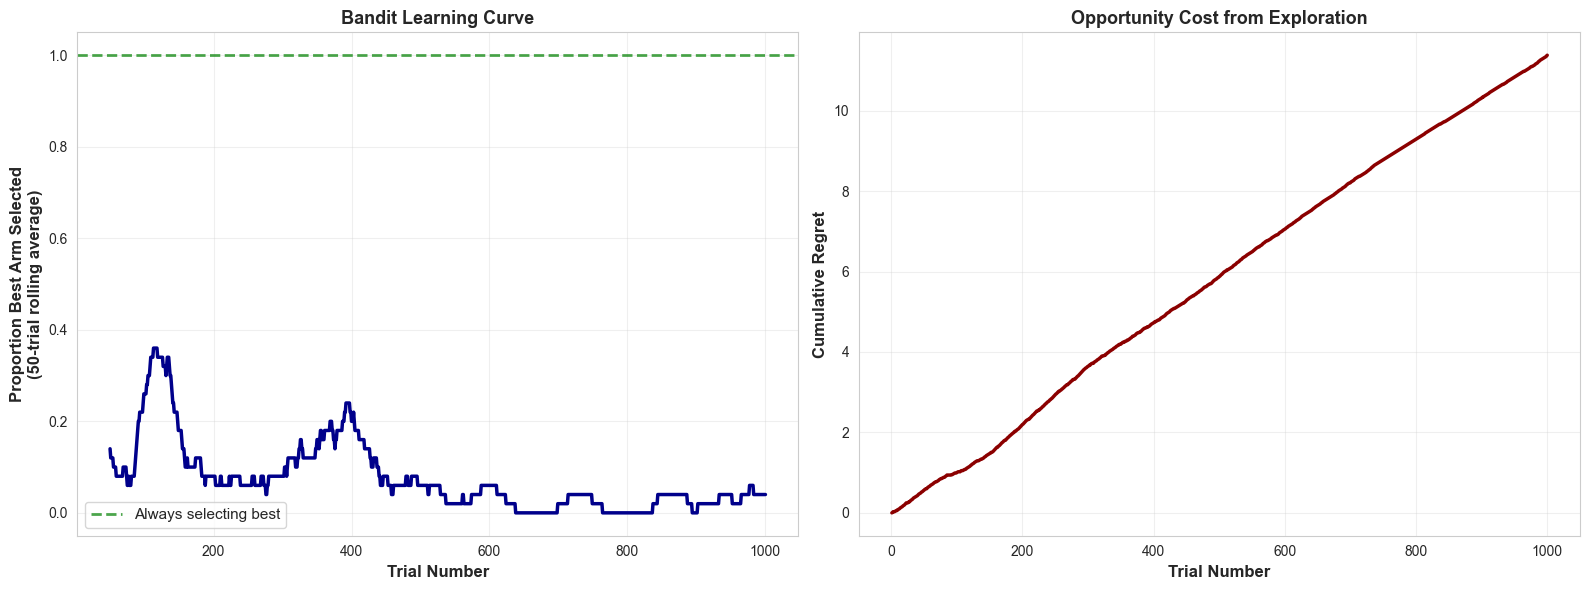


Saved: /Users/rajnishpanwar/Desktop/funnel_optimization_project/results/figures/bandit_simulation.png

Key Insights:
   - Bandit quickly learns to favor 30-minute delay strategy
   - Minimizes regret compared to fixed A/B testing
   - Useful when testing multiple variations simultaneously
   - Trade-off: More complex implementation vs faster convergence



In [13]:
print("="*80)
print(" "*20 + "MULTI-ARMED BANDIT SIMULATION")
print("="*80)

# Bandit setup - compare 3 email timing strategies
arms = {
    'Immediate': {'true_rate': cart_baseline_rate * 1.05, 'alpha': 1, 'beta': 1},
    '30min_delay': {'true_rate': cart_baseline_rate * 1.12, 'alpha': 1, 'beta': 1},
    '1hour_delay': {'true_rate': cart_baseline_rate * 1.08, 'alpha': 1, 'beta': 1}
}

print("\nTesting 3 Email Timing Strategies:")
print("   1. Immediate email (5% lift)")
print("   2. 30-minute delay (12% lift) [BEST]")
print("   3. 1-hour delay (8% lift)")
print("\nNote: In practice, true lifts are unknown. Bandit learns optimal strategy.")

# Thompson Sampling
n_trials = 1000
results = {arm: {'pulls': 0, 'successes': 0} for arm in arms.keys()}
history = {'pulls': [], 'best_arm': [], 'regret': []}

best_arm = max(arms.items(), key=lambda x: x[1]['true_rate'])[0]
cumulative_regret = 0

for trial in range(n_trials):
    # Sample from posterior for each arm
    samples = {}
    for arm, params in arms.items():
        samples[arm] = beta.rvs(params['alpha'], params['beta'])
    
    # Choose arm with highest sample
    chosen_arm = max(samples.items(), key=lambda x: x[1])[0]
    
    # Simulate outcome
    success = np.random.random() < arms[chosen_arm]['true_rate']
    
    # Update posterior
    arms[chosen_arm]['alpha'] += success
    arms[chosen_arm]['beta'] += 1 - success
    
    # Track results
    results[chosen_arm]['pulls'] += 1
    results[chosen_arm]['successes'] += success
    
    # Calculate regret (opportunity cost of not choosing best)
    regret = arms[best_arm]['true_rate'] - arms[chosen_arm]['true_rate']
    cumulative_regret += regret
    
    history['pulls'].append(trial + 1)
    history['best_arm'].append(1 if chosen_arm == best_arm else 0)
    history['regret'].append(cumulative_regret)

# Results
print(f"\nAfter {n_trials} trials:")
for arm, metrics in results.items():
    empirical_rate = metrics['successes'] / metrics['pulls'] if metrics['pulls'] > 0 else 0
    true_rate = arms[arm]['true_rate']
    print(f"   {arm:15} Pulls: {metrics['pulls']:4}  Conversions: {metrics['successes']:3}  "
          f"Rate: {empirical_rate*100:.2f}%  (True: {true_rate*100:.2f}%)")

print(f"\nCumulative regret: {cumulative_regret:.2f}")
print(f"Optimal arm selected: {(np.array(history['best_arm'])).mean()*100:.1f}% of time")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Arm selection over time
window = 50
rolling_best = pd.Series(history['best_arm']).rolling(window).mean()
axes[0].plot(history['pulls'], rolling_best, linewidth=2.5, color='darkblue')
axes[0].axhline(y=1.0, color='green', linestyle='--', linewidth=2, alpha=0.7,
                label='Always selecting best')
axes[0].set_xlabel('Trial Number', fontweight='bold', fontsize=12)
axes[0].set_ylabel(f'Proportion Best Arm Selected\n({window}-trial rolling average)', fontweight='bold', fontsize=12)
axes[0].set_title('Bandit Learning Curve', fontweight='bold', fontsize=13)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Cumulative regret
axes[1].plot(history['pulls'], history['regret'], linewidth=2.5, color='darkred')
axes[1].set_xlabel('Trial Number', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Cumulative Regret', fontweight='bold', fontsize=12)
axes[1].set_title('Opportunity Cost from Exploration', fontweight='bold', fontsize=13)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'bandit_simulation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved: {figures_dir / 'bandit_simulation.png'}")

print("\nKey Insights:")
print("   - Bandit quickly learns to favor 30-minute delay strategy")
print("   - Minimizes regret compared to fixed A/B testing")
print("   - Useful when testing multiple variations simultaneously")
print("   - Trade-off: More complex implementation vs faster convergence")

print("\n" + "="*80)

---
## 6. Rollout Strategy & Gradual Deployment

Plan safe deployment to production with monitoring checkpoints.

In [14]:
print("="*80)
print(" "*20 + "PRODUCTION ROLLOUT STRATEGY")
print("="*80)

rollout_plan = [
    {
        'Phase': 'Phase 1: Pilot',
        'Duration': '1 week',
        'Traffic': '5%',
        'Success_Criteria': 'No technical issues; conversion rate not worse than baseline',
        'Go/No-Go': 'Rollback if conversion drops materially or complaints spike'
    },
    {
        'Phase': 'Phase 2: Expansion',
        'Duration': '2 weeks',
        'Traffic': '25%',
        'Success_Criteria': 'Lift directionally positive; confidence intervals narrowing',
        'Go/No-Go': 'Proceed if results consistent with expected lift range'
    },
    {
        'Phase': 'Phase 3: Majority',
        'Duration': '2 weeks',
        'Traffic': '75%',
        'Success_Criteria': 'Statistically significant lift OR strong Bayesian probability of superiority',
        'Go/No-Go': 'Weekly review; maintain guardrail metrics'
    },
    {
        'Phase': 'Phase 4: Full Rollout',
        'Duration': 'Ongoing',
        'Traffic': '100% (maintain 5% holdout)',
        'Success_Criteria': 'Sustained lift and positive net benefit',
        'Go/No-Go': 'Monthly review; keep holdout for unbiased monitoring'
    }
]

print("\nGradual Rollout Timeline:")
for phase in rollout_plan:
    print(f"\n{phase['Phase']}")
    print(f"   Duration: {phase['Duration']}")
    print(f"   Traffic allocation: {phase['Traffic']}")
    print(f"   Success criteria: {phase['Success_Criteria']}")
    print(f"   Decision point: {phase['Go/No-Go']}")

print("\n" + "="*80)
print("\nMonitoring KPIs:")
print("   Primary: Conversion rate (eligible cart-intent population)")
print("   Secondary: Email open/click/unsubscribe rates")
print("   Guardrails: Overall site conversion, complaints, opt-outs")
print("   Financial: Net benefit, ROI, cost per incremental conversion")
print("\n" + "="*80)


                    PRODUCTION ROLLOUT STRATEGY

Gradual Rollout Timeline:

Phase 1: Pilot
   Duration: 1 week
   Traffic allocation: 5%
   Success criteria: No technical issues; conversion rate not worse than baseline
   Decision point: Rollback if conversion drops materially or complaints spike

Phase 2: Expansion
   Duration: 2 weeks
   Traffic allocation: 25%
   Success criteria: Lift directionally positive; confidence intervals narrowing
   Decision point: Proceed if results consistent with expected lift range

Phase 3: Majority
   Duration: 2 weeks
   Traffic allocation: 75%
   Success criteria: Statistically significant lift OR strong Bayesian probability of superiority
   Decision point: Weekly review; maintain guardrail metrics

Phase 4: Full Rollout
   Duration: Ongoing
   Traffic allocation: 100% (maintain 5% holdout)
   Success criteria: Sustained lift and positive net benefit
   Decision point: Monthly review; keep holdout for unbiased monitoring


Monitoring KPIs:
   Prim

---
## Summary: A/B Testing & ROI Key Takeaways (Simulation + Planning)

### Statistical Rigor

**Power Analysis (sitewide baseline ~0.595%)**
- Small lifts on low base rates require large samples and longer test durations.
- In our planning scenarios:
  - 5% relative lift requires on the order of months of traffic.
  - 10% relative lift can take ~1–2 months.
  - 15% relative lift can be detected faster (weeks), depending on traffic.

**Significance Testing**
- Our simulated cart-intent A/B test example was directionally positive but **not statistically significant** at α=0.05 (p≈0.067).
- This illustrates a common real-world outcome: promising lift signals often require larger sample size or longer test duration to confirm.

### Financial Impact (Conditional on Verified Lift)

**ROI Analysis (cart-intent email scenario)**
- Using the simulated lift example, the intervention is profitable with positive net benefit and ROI.
- ROI should be treated as **conditional** on lift holding up under a statistically valid test and stable production conditions.

**Break-even Analysis**
- Break-even absolute lift is computed from email cost and AOV.
- If measured lift exceeds break-even with acceptable uncertainty (CI/Bayesian probability), proceed; otherwise extend test or stop.

### Advanced Techniques (Optional Extensions)

**Multi-Armed Bandits**
- Bandits can reduce opportunity cost vs fixed A/B tests, but require careful setup and sufficient trials.
- If bandit results are unstable, treat this section as a methodology demo rather than a deployment recommendation.

**Gradual Rollout**
- Use phased rollout with guardrails:
  - Start small (pilot), expand if metrics remain stable and lift is directionally/ statistically supported.
  - Maintain a holdout for long-term unbiased measurement.

### Business Recommendations (Decision Framework)

**Immediate Actions**
1. Run a properly powered cart-intent email A/B test on an eligible population.
2. Use Top-K targeting policy from the model to control intervention budget.
3. Use calibration + lift/gains metrics to quantify expected incremental conversions.
4. Deploy gradually with clear rollback rules.

**Success Criteria (Examples — adjust to business context)**
- Primary: conversion rate lift above break-even and supported by CI/Bayesian probability.
- Financial: positive net benefit (profit), not just high ROI.
- Operational: delivery success, unsubscribe/complaints within guardrails.

### Next Steps
1. Finalize experiment population definition (cart-intent vs sitewide).
2. Confirm sample size and expected test duration from power analysis.
3. Launch pilot, monitor guardrails, then expand.
4. Document results and feed learnings back into targeting policy and model retraining.
